In [1]:
%tensorflow_version 1.x


from google.colab import drive 


TensorFlow 1.x selected.


In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [12]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt

import os
from PIL import Image
import tensorflow as tf
from tensorflow.python.framework import ops

ROWS = 64
COLS = 64
CHANNELS = 3
CLASSES = 2

In [4]:
DIRECTORY = r"/content/drive/MyDrive/dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [5]:

def load_dataset():
    x_list=[]
    y_list=[]
    class_list=[]
    path1 = os.path.join(DIRECTORY,CATEGORIES[0])
    path2 = os.path.join(DIRECTORY,CATEGORIES[1])
    list1=os.listdir(path1)
    list2=os.listdir(path2)
    for img1,img2 in zip(list1,list2):
        img_path1 = os.path.join(path1, img1)
        image1=Image.open(img_path1)
        image1 = image1.resize((64,64))
        image1 =np.array( image1)
        img_path2 = os.path.join(path2, img2)
        image2 = Image.open(img_path2)
        image2 = image2.resize((64, 64))
        image2 = np.array(image2)
        x_list.append(image1)
        x_list.append(image2)
        y_list.append([1])
        y_list.append([0])
        class_list.append(CATEGORIES[0])
        class_list.append(CATEGORIES[1])
        if ( len (x_list) > 249):    #to limit the number ( crappy PC)
            return (x_list,y_list,class_list)

In [6]:
def data_flat_split():
    x_list, y_list, class_list = load_dataset()

    print(len(x_list), " --", len(y_list), "----", len(class_list))

    print(x_list[0].shape)
    print(x_list[1].shape)
    print(x_list[100].shape)
    train_set_x_orig= np.array(x_list[0:209])
    train_set_y = np.array(y_list[0:209]).T
    train_classes=np.array(class_list[0:209])
    test_set_x_orig = np.array( x_list[209:])
    test_set_y = np.array(y_list[209:]).T
    test_classes = np.array(class_list[209:])

    train_set_x_flatten = train_set_x_orig/255.
    test_set_x_flatten = test_set_x_orig/255.
    train_set_y = convert_to_one_hot(train_set_y, 2).T
    test_set_y = convert_to_one_hot(test_set_y, 2).T
    return (train_set_x_flatten,test_set_x_flatten,train_set_y,test_set_y,train_classes,test_classes)

In [8]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y
    

In [9]:
train_set_x_flatten,test_set_x_flatten,train_set_y,test_set_y,train_classes,test_classes=data_flat_split()

print ( train_set_x_flatten.shape,"---",train_set_y.shape)

250  -- 250 ---- 250
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(209, 64, 64, 3) --- (209, 2)


1 - Create placeholders:
TensorFlow requires that we create placeholders for the input data that will be fed into the model when running the session.

We will implement the function below to create placeholders for the input image X and the output Y. We should not define the number of training examples for the moment. To do so, we could use "None" as the batch size, it will give us the flexibility to choose it later.

Arguments:
n_H0 - scalar, height of an input image
n_W0 - scalar, width of an input image
n_C0 - scalar, number of channels of the input
n_y - scalar, number of classes

Returns:
X - placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
Y - placeholder for the input labels, of shape [None, n_y] and dtype "float"

In [10]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):

    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0), name="X")
    Y = tf.placeholder(tf.float32, shape=(None, n_y), name="Y")
    
    return X, Y

In [13]:
X, Y = create_placeholders(ROWS, COLS, CHANNELS, CLASSES)
print ("X = ", X)
print ("Y = ", Y)

X =  Tensor("X:0", shape=(?, 64, 64, 3), dtype=float32)
Y =  Tensor("Y:0", shape=(?, 2), dtype=float32)


2 - Initialize parameters:
We will initialize weights/filters W1 and W2 using `tf.contrib.layers.xavier_initializer()`. We don't need to worry about bias variables as we will soon see that TensorFlow functions take care of the bias. Note also that we will only initialize the weights/filters for the conv2d functions. TensorFlow initializes the layers for the fully connected part automatically. We will talk more about that later.

The dimensions for each group of filters will be: [weight, height, channels, filters]

In [14]:
def initialize_parameters():
    
    W1 = tf.get_variable("W1", [4, 4, 3, 32], initializer = tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable("W2", [2, 2, 32, 32], initializer = tf.contrib.layers.xavier_initializer())

    parameters = {"W1": W1,
                  "W2": W2}
   
    return parameters

In [15]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = ", parameters["W1"].eval()[1,1,1])
    print("W2 = ", parameters["W2"].eval()[1,1,1])

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1 =  [ 0.09911936 -0.00657279 -0.07778946  0.05373583 -0.04751974  0.07503689
  0.09002561  0.06733937 -0.07250324 -0.02404843  0.01756416  0.08964258
 -0.06111021 -0.05347591  0.03678826 -0.02638231  0.00306334 -0.07827133
 -0.05164623 -0.06578716 -0.0848368   0.06240561  0.03164112 -0.09040479
 -0.06059045 -0.02168537  0.09327344  0.01673841  0.04175929  0.10324468
  0.005458    0.02030531]
W2 =  [-0.0120503   0.09888016  0.0531057   0.11054365 -0.0435883   0.06123522
 -0.11715537  0.09991591  0.10421185  0.00848007  0.0094102  -0.10568817
  0.00545818 -0.13570689  0.05529535  0.14507137 -0.10096008  0.05358538
  0.01741806 -

3 - Forward propagation:
In TensorFlow, there are built-in functions that carry out the convolution steps for us.

tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME'): given an input X and a group of filters W1, this function convolves W1's filters on X. The third input ([1,f,f,1]) represents the strides for each dimension of the input (m, n_H_prev, n_W_prev, n_C_prev).
tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'): given an input A, this function uses a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window.
tf.nn.relu(Z1): computes the elementwise ReLU of Z1 (which can be any shape).
tf.contrib.layers.flatten(P): given an input P, this function flattens each example into a 1D vector it while maintaining the batch-size. It returns a flattened tensor with shape [batch_size, k].
tf.contrib.layers.fully_connected(F, num_outputs): given a the flattened input F, it returns the output computed using a fully connected layer.

In the last function above (tf.contrib.layers.fully_connected), the fully connected layer automatically initializes weights in the graph and keeps on training them as we train the model. We don't need to initialize those weights when initializing the parameters.

So we will implement the forward_propagation function below to build the following model: CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED.


 
In detail, we will use the following parameters for all the steps: - Conv2D: stride 1, padding is "SAME"
- ReLU
- Max pool: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
- Conv2D: stride 1, padding is "SAME"
- ReLU
- Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
- Flatten the previous output.
- FULLYCONNECTED (FC) layer: We'll apply fully connected layer without an non-linear activation function. We will not call the softmax here. This will result in 2 neurons in the output layer, which then get passed later to a softmax. In TensorFlow, the softmax and cost function are lumped together into a single function, which you'll call in a different function when computing the cost.

Arguments:
X - input dataset placeholder, of shape (input size, number of examples)
parameters - python dictionary containing our parameters "W1", "W2"

Returns:
Z3 - the output of the last LINEAR unit

In [17]:
def forward_propagation(X, parameters):
    # Retrieving the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    print("Z1 shape", Z1.shape)
    
    # RELU
    A1 = tf.nn.relu(Z1)
    print("A1 shape", A1.shape)
    
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    print("P1 shape", P1.shape)
    
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    print("Z2 shape", Z2.shape)
    
    # RELU
    A2 = tf.nn.relu(Z2)
    print("A2 shape", A2.shape)
    
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    print("P2 shape", P2.shape)
    
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    print("P2 FLATTEN shape", P2.shape)
    
    # FULLY-CONNECTED without non-linear activation function (not call softmax).
    # 2 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P2, CLASSES, activation_fn=None)
    print("Z3 shape", Z3.shape)

    return Z3

In [18]:
tf.reset_default_graph()
with tf.Session() as sess:
    X, Y = create_placeholders(ROWS, COLS, CHANNELS, CLASSES)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,CLASSES)})
    print("Z3 =", a)
    print("Z3 shape =", a.shape)

Z1 shape (?, 64, 64, 32)
A1 shape (?, 64, 64, 32)
P1 shape (?, 8, 8, 32)
Z2 shape (?, 8, 8, 32)
A2 shape (?, 8, 8, 32)
P2 shape (?, 2, 2, 32)
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
P2 FLATTEN shape (?, 128)
Z3 shape (?, 2)
Z3 = [[-0.6550324   1.4974239 ]
 [-0.37945104  1.4550192 ]]
Z3 shape = (2, 2)


4 - Compute cost:
In TensorFlow, there are built-in functions that carry out the convolution steps for us.

tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y): computes the softmax entropy loss. This function both computes the softmax activation function as well as the resulting loss.
tf.reduce_mean: computes the mean of elements across dimensions of a tensor. Use this to sum the losses over all the examples to get the overall cost.

Arguments:
Z3 - output of forward propagation (output of the last LINEAR unit), of shape (CLASSES, number of examples)
Y - "true" labels vector placeholder, same shape as Z3

Returns:
cost - Tensor of the cost function

In [19]:
def compute_cost(Z3, Y):

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    return cost

In [20]:
tf.reset_default_graph()
with tf.Session() as sess:
    X, Y = create_placeholders(ROWS, COLS, CHANNELS, CLASSES)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,CLASSES)})
    print("cost = ", a)

Z1 shape (?, 64, 64, 32)
A1 shape (?, 64, 64, 32)
P1 shape (?, 8, 8, 32)
Z2 shape (?, 8, 8, 32)
A2 shape (?, 8, 8, 32)
P2 shape (?, 2, 2, 32)
P2 FLATTEN shape (?, 128)
Z3 shape (?, 2)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

cost =  0.5756288


5 - Mini-Batch Gradient descent:
I copied mini-batches function from my last Deep Network TensorFlow tutorial, and adopted it to new data-set shape:

Arguments:
X - input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
Y - true "label" vector (containing 0 if masked, 1 if dnot), of shape (1, number of examples) (m, n_y)
mini_batch_size - size of the mini-batches, integer

Returns:
mini_batches - list of synchronous (mini_batch_X, mini_batch_Y)

In [21]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    # number of training examples
    m = X.shape[0]                  
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

6 - Model:
Finally we will merge the helper functions we implemented above to build a model. We will train it on my masks data-set.

The model below should:

create placeholders
initialize parameters
forward propagate
compute the cost
create an optimizer

Finally we will create a session and run a for loop for num_epochs, get the mini-batches, and then for each mini-batch we will optimize the function.

So we'll implement a three-layer ConvNet in Tensorflow: CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED.

Arguments:
X_train - training set, of shape (None, ROWS, COLS, CHANNELS)
Y_train - test set, of shape (None, n_y = CLASSES)
X_test - training set, of shape (None, ROWS, COLS, CHANNELS)
Y_test - test set, of shape (None, n_y = CLASSES)
learning_rate - learning rate of the optimization
num_epochs - number of epochs of the optimization loop
minibatch_size - size of a minibatch
print_cost - True to print the cost every 100 epochs

Returns:
train_accuracy - real number, accuracy on the train set (X_train)
test_accuracy - real number, testing accuracy on the test set (X_test)
parameters - parameters learnt by the model. They can then be used to predict.

In [22]:
tf.reset_default_graph()
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 200, minibatch_size = 64, print_cost = True):

    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1] 
    
    # To keep track of the cost
    costs = []                                        
    
    # Createing Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initializing parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Building the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Adding cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Defining the tensorflow optimizer. Using an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initializing all the variables globally
    init = tf.global_variables_initializer()
     
    # Starting the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Runing the initialization
        sess.run(init)
        
        # Doing the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            # number of minibatches of size minibatch_size in the train set
            num_minibatches = int(m / minibatch_size)
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")     
        
        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        
        # Saving our trained model
        saver = tf.train.Saver()
        tf.add_to_collection('predict_op', predict_op)
        saver.save(sess, './my-CNN-model')        
                
        return train_accuracy, test_accuracy, parameters

Z1 shape (?, 64, 64, 32)
A1 shape (?, 64, 64, 32)
P1 shape (?, 8, 8, 32)
Z2 shape (?, 8, 8, 32)
A2 shape (?, 8, 8, 32)
P2 shape (?, 2, 2, 32)
P2 FLATTEN shape (?, 128)
Z3 shape (?, 2)
Cost after epoch 0: 1.090170
Cost after epoch 5: 0.910301
Cost after epoch 10: 0.779835
Cost after epoch 15: 0.450450
Cost after epoch 20: 0.203999
Cost after epoch 25: 0.157514
Cost after epoch 30: 0.099863
Cost after epoch 35: 0.079657
Cost after epoch 40: 0.058011
Cost after epoch 45: 0.044009
Cost after epoch 50: 0.039821
Cost after epoch 55: 0.026994
Cost after epoch 60: 0.014982
Cost after epoch 65: 0.010515
Cost after epoch 70: 0.008105
Cost after epoch 75: 0.008017
Cost after epoch 80: 0.004877
Cost after epoch 85: 0.003882
Cost after epoch 90: 0.003843
Cost after epoch 95: 0.002650
Cost after epoch 100: 0.002306
Cost after epoch 105: 0.001937
Cost after epoch 110: 0.001759
Cost after epoch 115: 0.001779
Cost after epoch 120: 0.001406
Cost after epoch 125: 0.001318
Cost after epoch 130: 0.001200
C

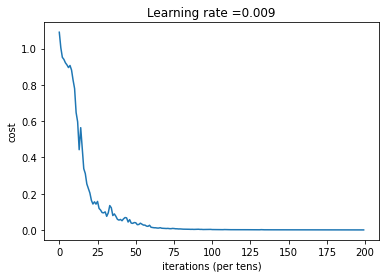

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 1.0


In [23]:
_, _, parameters = model(train_set_x_flatten, train_set_y,test_set_x_flatten,test_set_y)

7 - Test with your own image:
When we save the variables, it creates a .meta file. This file contains the graph structure. Therefore, we can import the meta graph using tf.train.import_meta_graph() and restore the values of the graph. Let's import the graph and see all tensors in the graph:

In [24]:
# delete the current graph
tf.reset_default_graph()

# import the graph from the file
imported_graph = tf.train.import_meta_graph('my-CNN-model.meta')

# list all the tensors in the graph
for tensor in tf.get_default_graph().get_operations():
    print (tensor.name)

X
Y
W1/Initializer/random_uniform/shape
W1/Initializer/random_uniform/min
W1/Initializer/random_uniform/max
W1/Initializer/random_uniform/RandomUniform
W1/Initializer/random_uniform/sub
W1/Initializer/random_uniform/mul
W1/Initializer/random_uniform
W1
W1/Assign
W1/read
W2/Initializer/random_uniform/shape
W2/Initializer/random_uniform/min
W2/Initializer/random_uniform/max
W2/Initializer/random_uniform/RandomUniform
W2/Initializer/random_uniform/sub
W2/Initializer/random_uniform/mul
W2/Initializer/random_uniform
W2
W2/Assign
W2/read
Conv2D
Relu
MaxPool
Conv2D_1
Relu_1
MaxPool_1
Flatten/flatten/Shape
Flatten/flatten/strided_slice/stack
Flatten/flatten/strided_slice/stack_1
Flatten/flatten/strided_slice/stack_2
Flatten/flatten/strided_slice
Flatten/flatten/Reshape/shape/1
Flatten/flatten/Reshape/shape
Flatten/flatten/Reshape
fully_connected/weights/Initializer/random_uniform/shape
fully_connected/weights/Initializer/random_uniform/min
fully_connected/weights/Initializer/random_uniform/max

In [27]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

In [40]:
#test_image = "cat.jpg"
import cv2
test_image = "/content/drive/MyDrive/dataset/with_mask/0_0_≈˙◊¢ 2020-02-25 185823.png"
my_image = read_image(test_image).reshape(1, ROWS, COLS, CHANNELS)
X = my_image / 255.
#print(X.shape)

checkpoint_path = 'my-CNN-model'
tf.reset_default_graph()

with tf.Session() as sess:

    ## Load the entire model previuosly saved in a checkpoint
    print("Load the model from path", checkpoint_path)
    the_Saver = tf.train.import_meta_graph(checkpoint_path + '.meta')
    the_Saver.restore(sess, checkpoint_path)

    ## Identify the predictor of the Tensorflow graph
    predict_op = tf.get_collection('predict_op')[0]

    ## Identify the restored Tensorflow graph
    dataFlowGraph = tf.get_default_graph()

    ## Identify the input placeholder to feed the images into as defined in the model 
    x = dataFlowGraph.get_tensor_by_name("X:0")

    ## Predict the image category
    prediction = sess.run(predict_op, feed_dict = {x: X})

    print("\nThe predicted image class is:", np.squeeze(prediction))

Load the model from path my-CNN-model
INFO:tensorflow:Restoring parameters from my-CNN-model

The predicted image class is: 0
